In [1]:
import pathlib
import matplotlib as mpl
import pandas as pd
import scanpy as sc
import seaborn as sns

%matplotlib inline
from matplotlib import pyplot as plt

sns.set_style("ticks")

savefig_args = {
    "dpi": 300,
    "bbox_inches": "tight",
    "pad_inches": 0.2,
    "transparent": True,
}

mpl.rc("savefig", dpi=300)
output_dir = "/home/michaelswift/repos/tabula-bursa/analysis/figures/ED/ED2_mem_b"

pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
sc.settings.figdir = output_dir
output_suffix = ""
output_formats = [".png", ".svg", ".pdf"]

def save_figure(
    fig,
    name,
    output_dir=output_dir,
    output_suffix=output_suffix,
    output_formats=output_formats,
    savefig_args=savefig_args,
):
    for output_format in output_formats:
        fig.savefig(
            output_dir + "/" + name + output_suffix + output_format, **savefig_args
        )
    return None

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 100)
%run ../helper.py

## Load the Data

In [2]:
celltype_file = "MB"
celltype = 'MB'
celltypist = 'Memory B|ABC|GC'

In [3]:
adata = sc.read_h5ad(
    f"../../../data/{celltype_file}.h5ad.gz", backed = 'r'
)

In [4]:
# Map SW vs NS
adata.obs.loc[:,"switched"] = adata.obs.c_call.map(IGH_switched())
# Simplify celltypist labels
adata.obs['celltypist'] = adata.obs['celltypist'].map(celltypist_simpler).fillna(adata.obs['celltypist'])
adata = adata[adata.obs.celltypist.str.contains(celltypist)].to_memory()
print(adata.obs.shape[0], "cells remaining after filtered a sneaky non B cells")
# filter to hq single b
adata = adata[adata.obs.probable_hq_single_b_cell == 'True']
print(adata.obs.shape[0], "cells remaining after filtered out probable doublets")
# remove small amount of nan and IGKC
adata = adata[adata.obs.c_call.isin(IGH_switched().keys())]
print(adata.obs.shape[0], "cells remaining after filtering out cells without assemblies")

190546 cells remaining after filtered a sneaky non B cells
156291 cells remaining after filtered out probable doublets
75633 cells remaining after filtering out cells without assemblies


In [5]:
adata.obs.loc[:,'celltypist_mod'] = adata.obs['celltypist'].str.replace("Memory B cells", "Memory").values

/home/michaelswift/miniconda3/envs/muon3/lib/python3.11/site-packages/pandas/core/indexing.py:1761: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obj[key] = value


## clustering

/home/michaelswift/miniconda3/envs/muon3/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/michaelswift/miniconda3/envs/muon3/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/michaelswift/miniconda3/envs/muon3/lib/python3.11/si

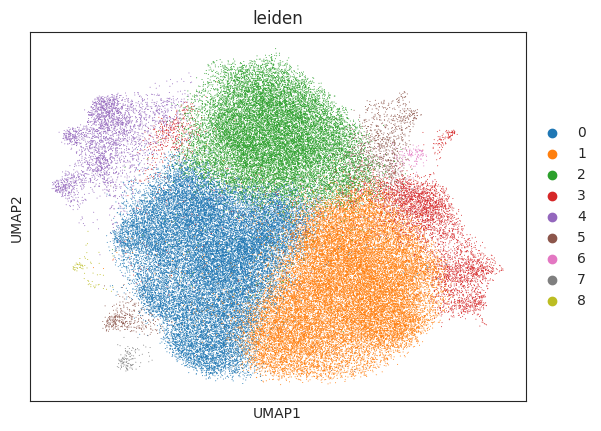

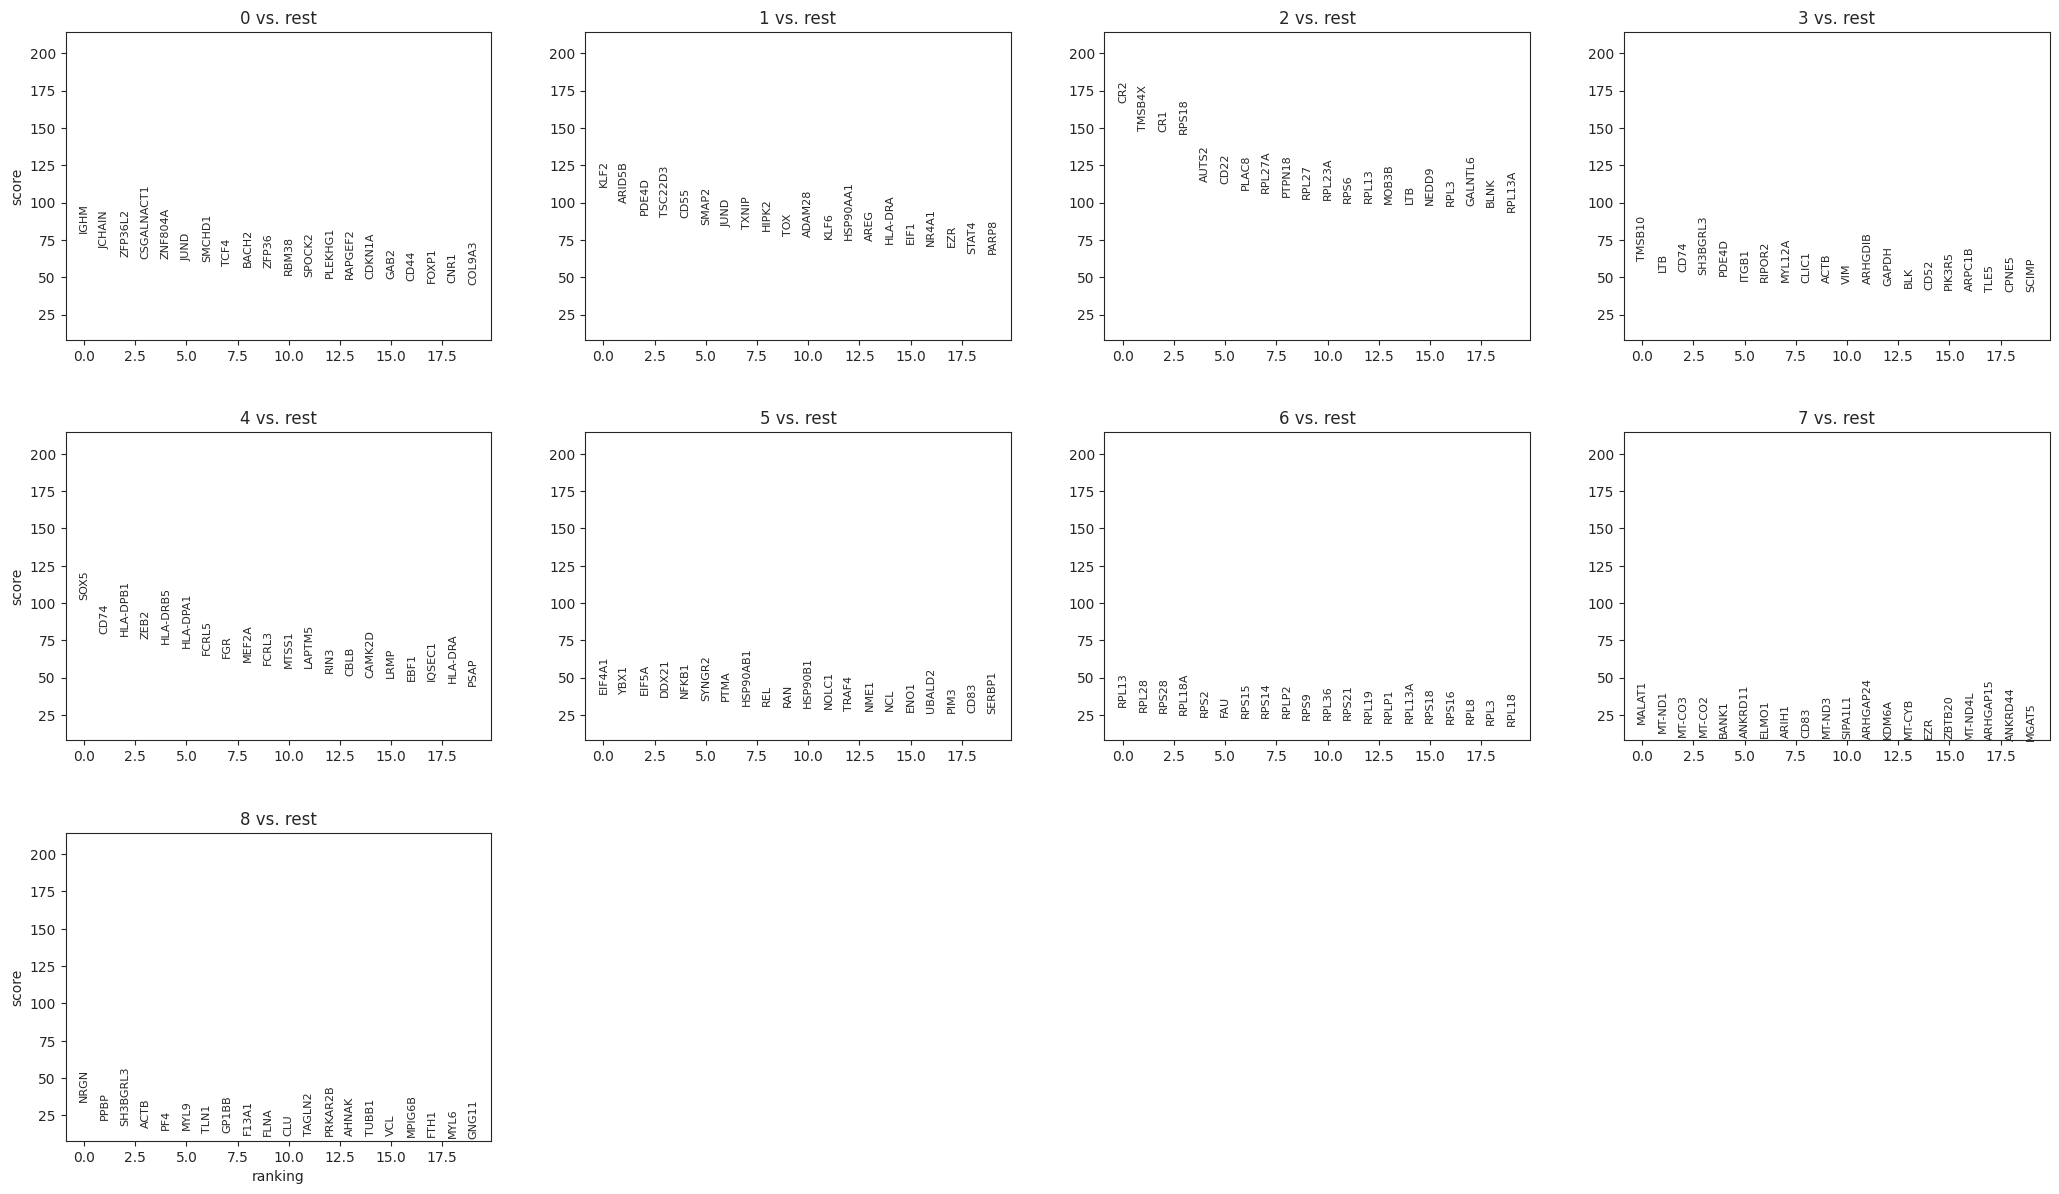

In [6]:
sc.pp.neighbors(adata, use_rep="X_scVI_all", n_neighbors=20)
sc.tl.umap(
    adata,
)
sc.tl.leiden(adata, resolution = 0.4)
sc.pl.umap(adata, color = 'leiden', size = 2)
sc.tl.rank_genes_groups(adata, groupby="leiden")
sc.pl.rank_genes_groups(adata)

# Create a CR score to classify cells with high CR expression

In [7]:
sc.tl.score_genes(adata, gene_list=['CR2', 'CR1', "CD22"], score_name="CR score")

I'm seeing a 3 major modes of Complement Receptor expression, could attempt to fit a model, but I'll just use a heuristic cutoff here 

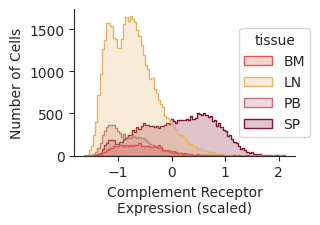

In [8]:
#g = sns.displot(data = adata.obs, x = 'CR score', hue = 'tissue', height = 1.9, aspect = 1.5, palette=get_tissue_colors())
#g = sns.kdeplot(data=adata.obs, x='CR score', hue='tissue', bw_adjust=.1, palette=get_tissue_colors(), common_norm=False)
height = 1.9
aspect = 1.5
width = aspect * height

plt.figure(figsize=(width, height))
g = sns.histplot(data=adata.obs, x='CR score', hue='tissue', element='step', palette=get_tissue_colors())
adata.obs['CD21_status'] = np.where(adata.obs['CR score'] > 0, "-CD21++", "")

g.set(yscale = 'linear', ylabel = "Number of Cells", xlabel = "Complement Receptor\nExpression (scaled)")
#g.ax.tick_params(axis='x', which = 'minor', length=0)
sns.move_legend(g, loc = 'right', bbox_to_anchor=(1.1,0.5))
sns.despine()
save_figure(g.figure, "CR_score_distribution")

In [9]:
# Manual Granular labels by adding switching information and CD21 (CR) status to 
adata.obs.loc[:,"subtype"] = adata.obs.switched.astype(str) + "-" +  adata.obs['celltypist_mod'].astype(str) + adata.obs['CD21_status']
adata.obs['subtype'].to_csv("outputs/MB_subtypes.tab", sep = '\t')

# Visualize Results

In [10]:
plt.style.use('../bursa.mplstyle')
sc.set_figure_params(dpi_save=150, frameon=False,
 vector_friendly=True, fontsize=6, figsize=(1,1), format='pdf', transparent=True)
size = 3

## Plot confusion matrix between leiden clusters and subtype markers

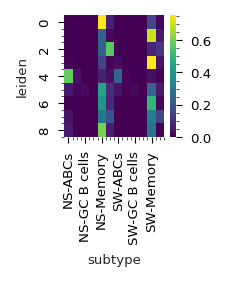

In [11]:
cmtx = sc.metrics.confusion_matrix("leiden", "subtype", adata.obs)
g = sns.heatmap(cmtx, cmap = 'viridis')
save_figure(g.figure, "cmtx_leiden_lit")

## UMAPS

In [12]:
# Performing downsampling for better umap visualization
abundant_subtypes = adata.obs.subtype.value_counts(normalize=True)
abundant_subtypes = abundant_subtypes[abundant_subtypes > 0.003].index.tolist()

print(abundant_subtypes)
adata = adata[adata.obs.subtype.isin(abundant_subtypes)]
min = adata.obs['subtype'].value_counts().min()
print(min)
# create new adata view
_adata = adata[adata.obs.groupby('subtype').sample(n=min, replace = False).index]

['NS-Memory', 'SW-Memory', 'NS-Memory-CD21++', 'SW-Memory-CD21++', 'NS-ABCs', 'SW-ABCs']
919


In [13]:
sc.pp.neighbors(_adata, use_rep='X_scVI_all', n_neighbors = 20)
sc.tl.umap(_adata)

/home/michaelswift/miniconda3/envs/muon3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/michaelswift/miniconda3/envs/muon3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/michaelswift/miniconda3/envs/muon3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


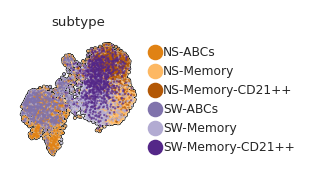

/home/michaelswift/miniconda3/envs/muon3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/michaelswift/miniconda3/envs/muon3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/michaelswift/miniconda3/envs/muon3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


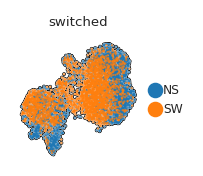

/home/michaelswift/miniconda3/envs/muon3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/michaelswift/miniconda3/envs/muon3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/michaelswift/miniconda3/envs/muon3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


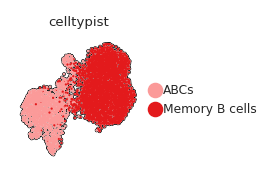

/home/michaelswift/miniconda3/envs/muon3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/michaelswift/miniconda3/envs/muon3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/michaelswift/miniconda3/envs/muon3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


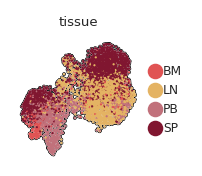

In [14]:
size = 4
color = "subtype"
sc.pl.umap(_adata, color = color, size = size,
 alpha = 0.7, add_outline=True, save=f"{color}_{celltype}_subsample", palette = get_mb_colors())

color = "switched"
palette = {"non-switched": "0.7", "switched": 'b'}
sc.pl.umap(_adata, color = color, size = size, alpha = 0.7, 
add_outline=True, save=f"{color}_{celltype}_subsample")

color = "celltypist"
sc.pl.umap(_adata, color = color, palette = get_bcelltype_colors_alt(), 
size = size, alpha = 1, add_outline=True, save=f"{color}_{celltype}_subsample")

color = "tissue"
sc.pl.umap(_adata, color = color, palette = get_tissue_colors(), 
size = size, alpha = 1, add_outline=True, save=f"{color}_{celltype}_subsample")



/home/michaelswift/miniconda3/envs/muon3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/michaelswift/miniconda3/envs/muon3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/michaelswift/miniconda3/envs/muon3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


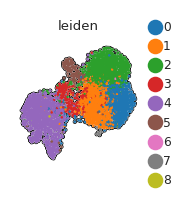

In [15]:
color = "leiden"
sc.pl.umap(_adata, color = color, size = 5, alpha = 1, add_outline=True, save=f"{color}_{celltype}_subsample")

/home/michaelswift/miniconda3/envs/muon3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/home/michaelswift/miniconda3/envs/muon3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


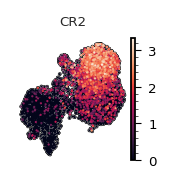

In [16]:
color = "CR2"
sc.pl.umap(_adata, color = color, palette = get_tissue_colors(), 
size = size, alpha = 1, add_outline=True, save=f"{color}_subsample")

## Differential Expression

/home/michaelswift/miniconda3/envs/muon3/lib/python3.11/site-packages/pandas/core/generic.py:6018: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self[name] = value


/home/michaelswift/miniconda3/envs/muon3/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


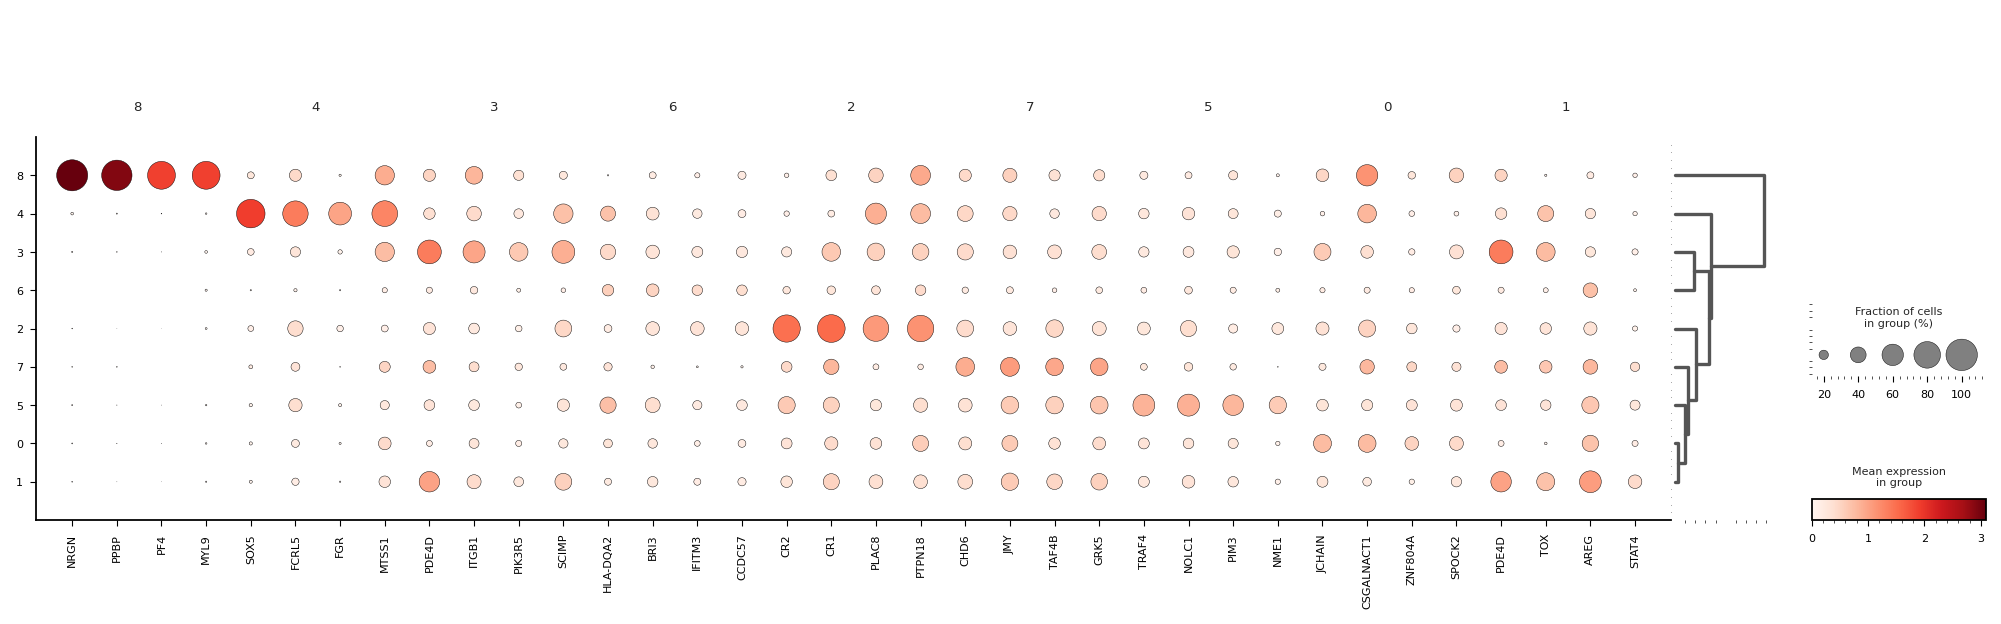

In [17]:
adata.obs.subtype = adata.obs.subtype.astype('category')
label = 'leiden'

sc.tl.dendrogram(adata, groupby=label)
sc.tl.rank_genes_groups(adata, groupby=label)
sc.tl.filter_rank_genes_groups(
    adata, min_fold_change=1, min_in_group_fraction=0.2, max_out_group_fraction=0.4
)
sc.pl.rank_genes_groups_dotplot(
    adata, key="rank_genes_groups_filtered", n_genes=4, save=f"{label}", 
)

/home/michaelswift/miniconda3/envs/muon3/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


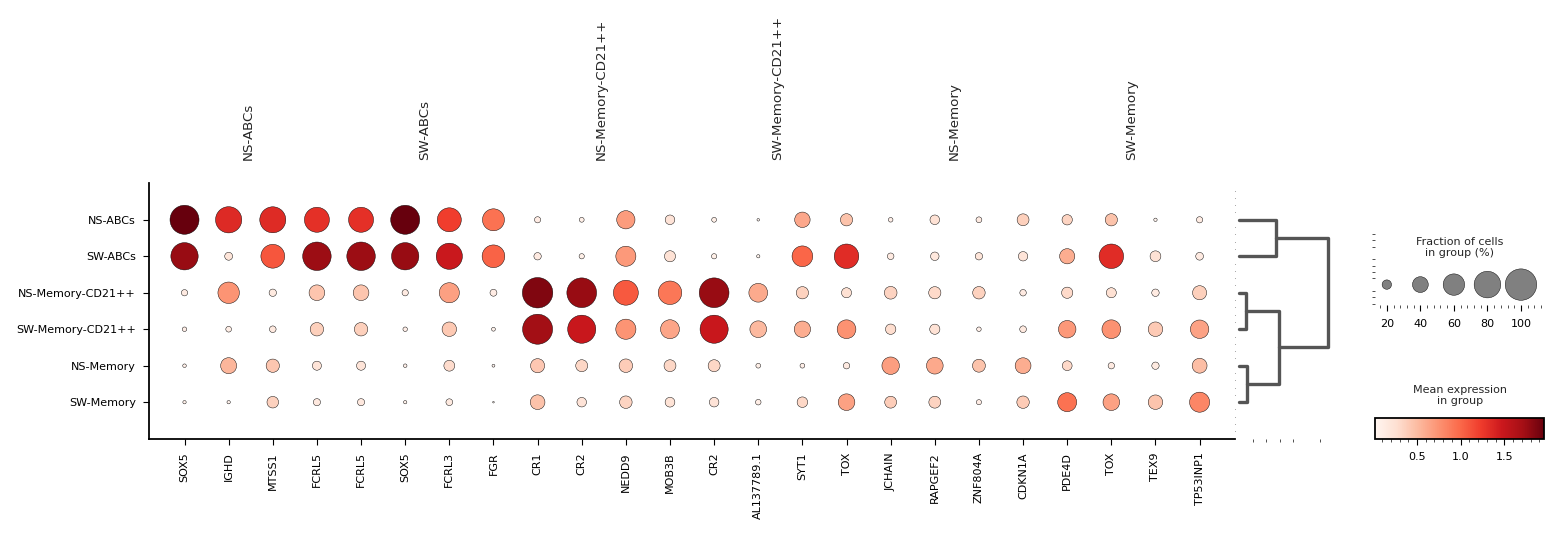

In [18]:
label = 'subtype'

sc.tl.dendrogram(adata, groupby=label)
sc.tl.rank_genes_groups(adata, groupby=label)
sc.tl.filter_rank_genes_groups(
    adata, min_fold_change=1, min_in_group_fraction=0.2, max_out_group_fraction=0.4
)
sc.pl.rank_genes_groups_dotplot(
    adata, key="rank_genes_groups_filtered", n_genes=4, save=f"{label}", 
)

## Create Dotplot from mixture on known markers and detected DE genes

In [33]:
# canonical markers
canonical_markers = ['MS4A1', "CD19", 'CD27', 'CD24', 'NT5E', "CD86", 'CD1C',
                         "IGHD", "ITGAX", "TBX21"]
transcriptional_markers = ["CR2", "AREG", "MYC", "MCTP1", "PDE4D", "SOX5", "PCDH9",  'FGR', "CDK4", "TOX"  ]
markers =  canonical_markers + transcriptional_markers



/home/michaelswift/miniconda3/envs/muon3/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


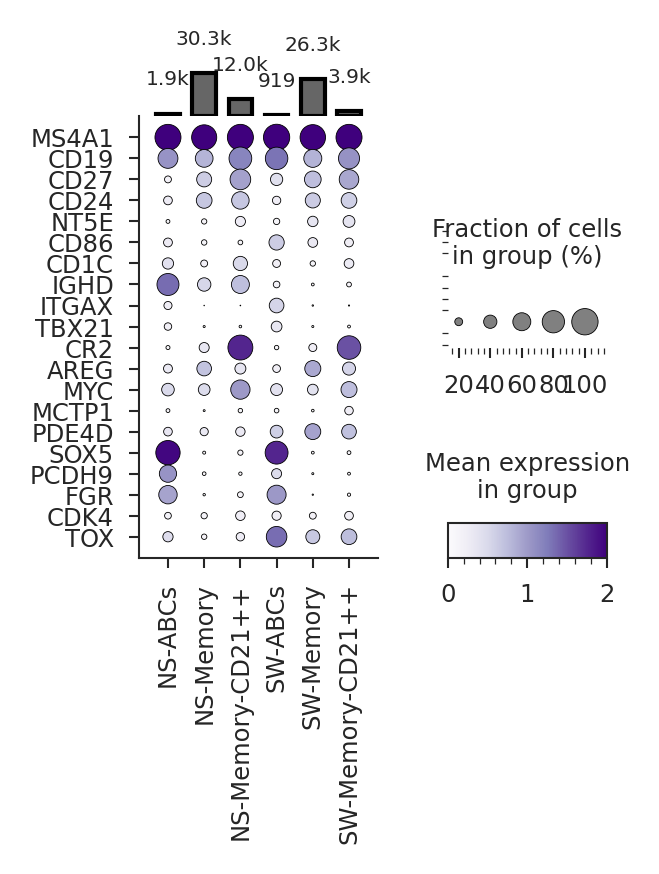

In [34]:
# Style
sns.set_style("ticks")
plt.style.use('../bursa.mplstyle')
# dot plot creation
dp = sc.pl.DotPlot(adata, markers, groupby= 'subtype', figsize = (2, 2.2), vmax = 2, vmin = 0,  expression_cutoff = 0)
dp.legend(width=0.8)
dp.swap_axes()
dp.add_totals(color = '0.4', size = 0.3,).style(dot_edge_color='black', largest_dot = 40 , dot_edge_lw=0.2, cmap = 'Purples').show()

# get axes for tweaking out
axes = dp.get_axes()

for child in axes['group_extra_ax'].get_children():
    if isinstance(child, mpl.text.Annotation):
       # print("bingo") # and do something
       # print(round_string(child.get_text()))
        child.set(rotation=90, verticalalignment='bottom')
       # print(child)
# First, remove the current title
axes['size_legend_ax'].set_title("")
axes['size_legend_ax'].tick_params(axis='x', which = 'minor', length=0)
axes['size_legend_ax'].tick_params(axis='x', labelsize=5)

# Then, create a new title using a text object
title = "% cells\nexpression > 0"
axes['size_legend_ax'].text(0, 0.8, title, transform=axes['size_legend_ax'].transAxes, 
                            va='center', ha='left', fontsize = 5)

title = "Mean Expression\n($log_2$ UMI per 10K)"
axes['color_legend_ax'].set_title("")
axes['color_legend_ax'].text(0, 2.2, title, transform=axes['color_legend_ax'].transAxes, 
                            va='center', ha='left', fontsize = 5)
axes['color_legend_ax'].tick_params(axis='x', labelsize=5)

# Get the bounding box of the main plot
mainplot_box = axes['mainplot_ax'].get_position()
for bar in axes['group_extra_ax'].patches:
    bar.set_edgecolor('none')
ax = axes['mainplot_ax']
# add label
y_text_loc = ax.get_yticks()[(len(canonical_markers)) - 5]
x_text_loc = ax.get_xticks()[-1] + 1
ax.text(x_text_loc, y_text_loc, 'Canonical', rotation=-90, fontsize = 6)
# add label
y_text_loc = ax.get_yticks()[13] + 4.5
x_text_loc = ax.get_xticks()[-1] + 1
ax.text(x_text_loc, y_text_loc, 'Data-Derived', rotation=-90, fontsize = 6)
save_figure(dp.fig, f"dotplot_{celltype}")

In [21]:
tissues = tissue_colors.keys()

/home/michaelswift/miniconda3/envs/muon3/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


/home/michaelswift/miniconda3/envs/muon3/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


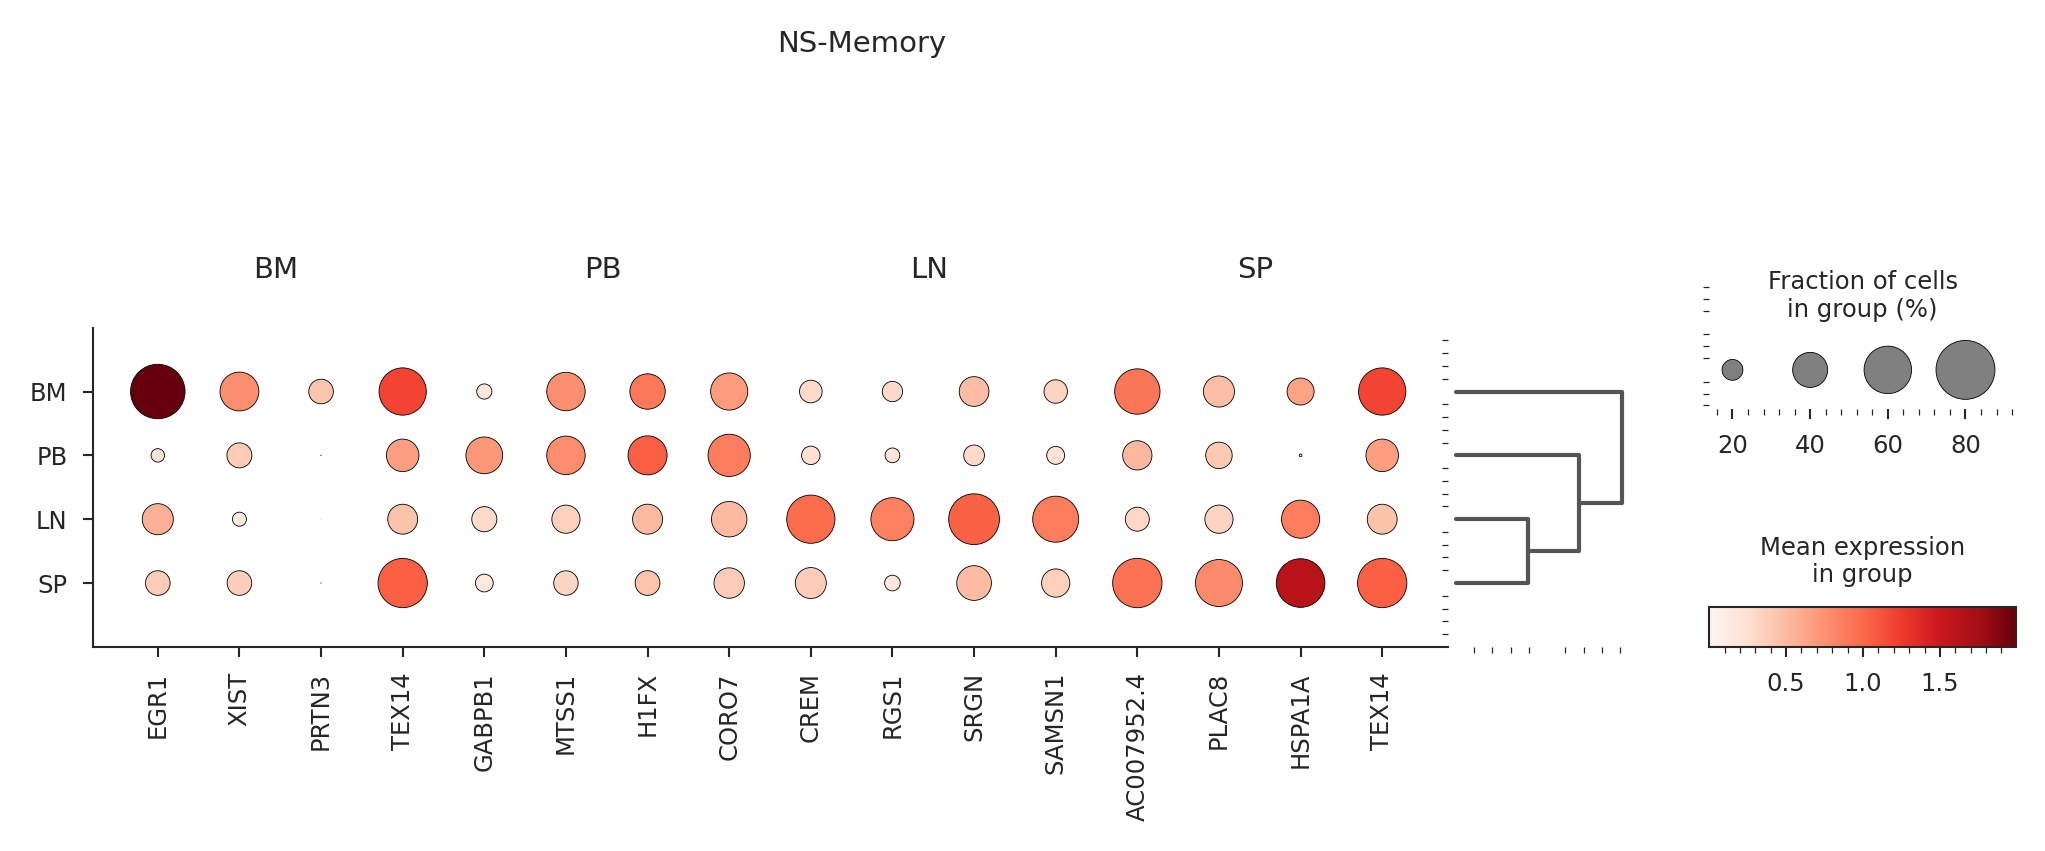

/home/michaelswift/miniconda3/envs/muon3/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


/home/michaelswift/miniconda3/envs/muon3/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


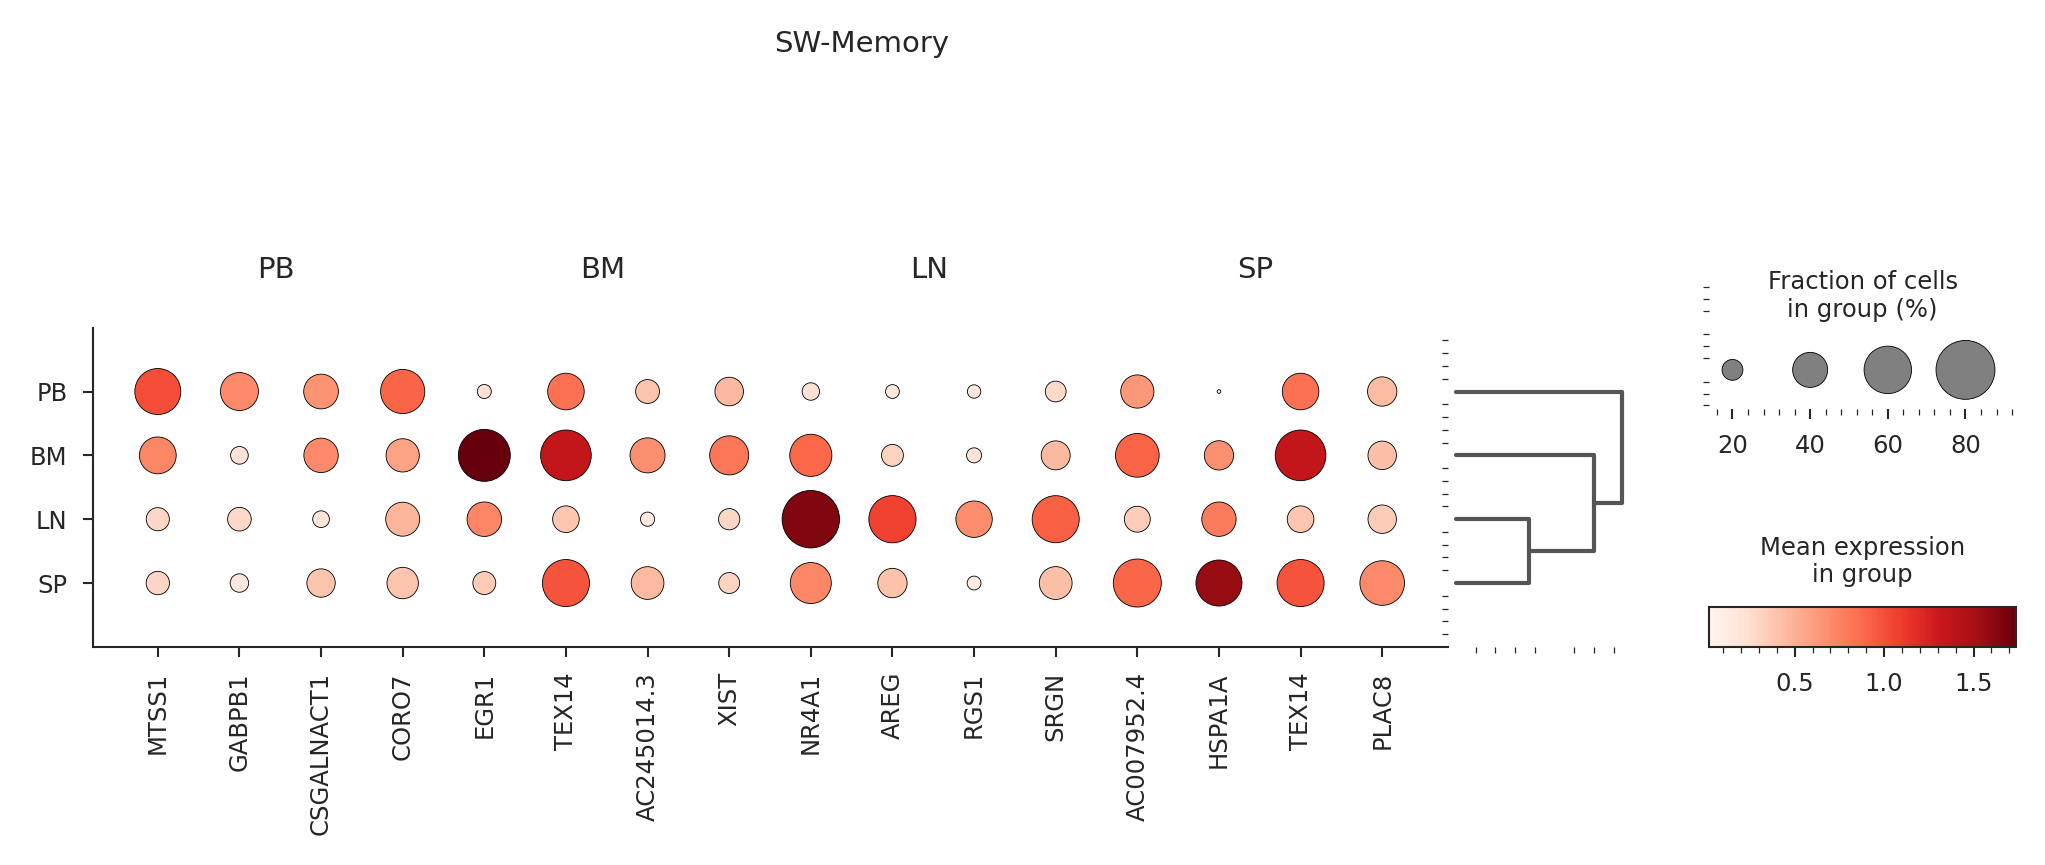

/home/michaelswift/miniconda3/envs/muon3/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


/home/michaelswift/miniconda3/envs/muon3/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


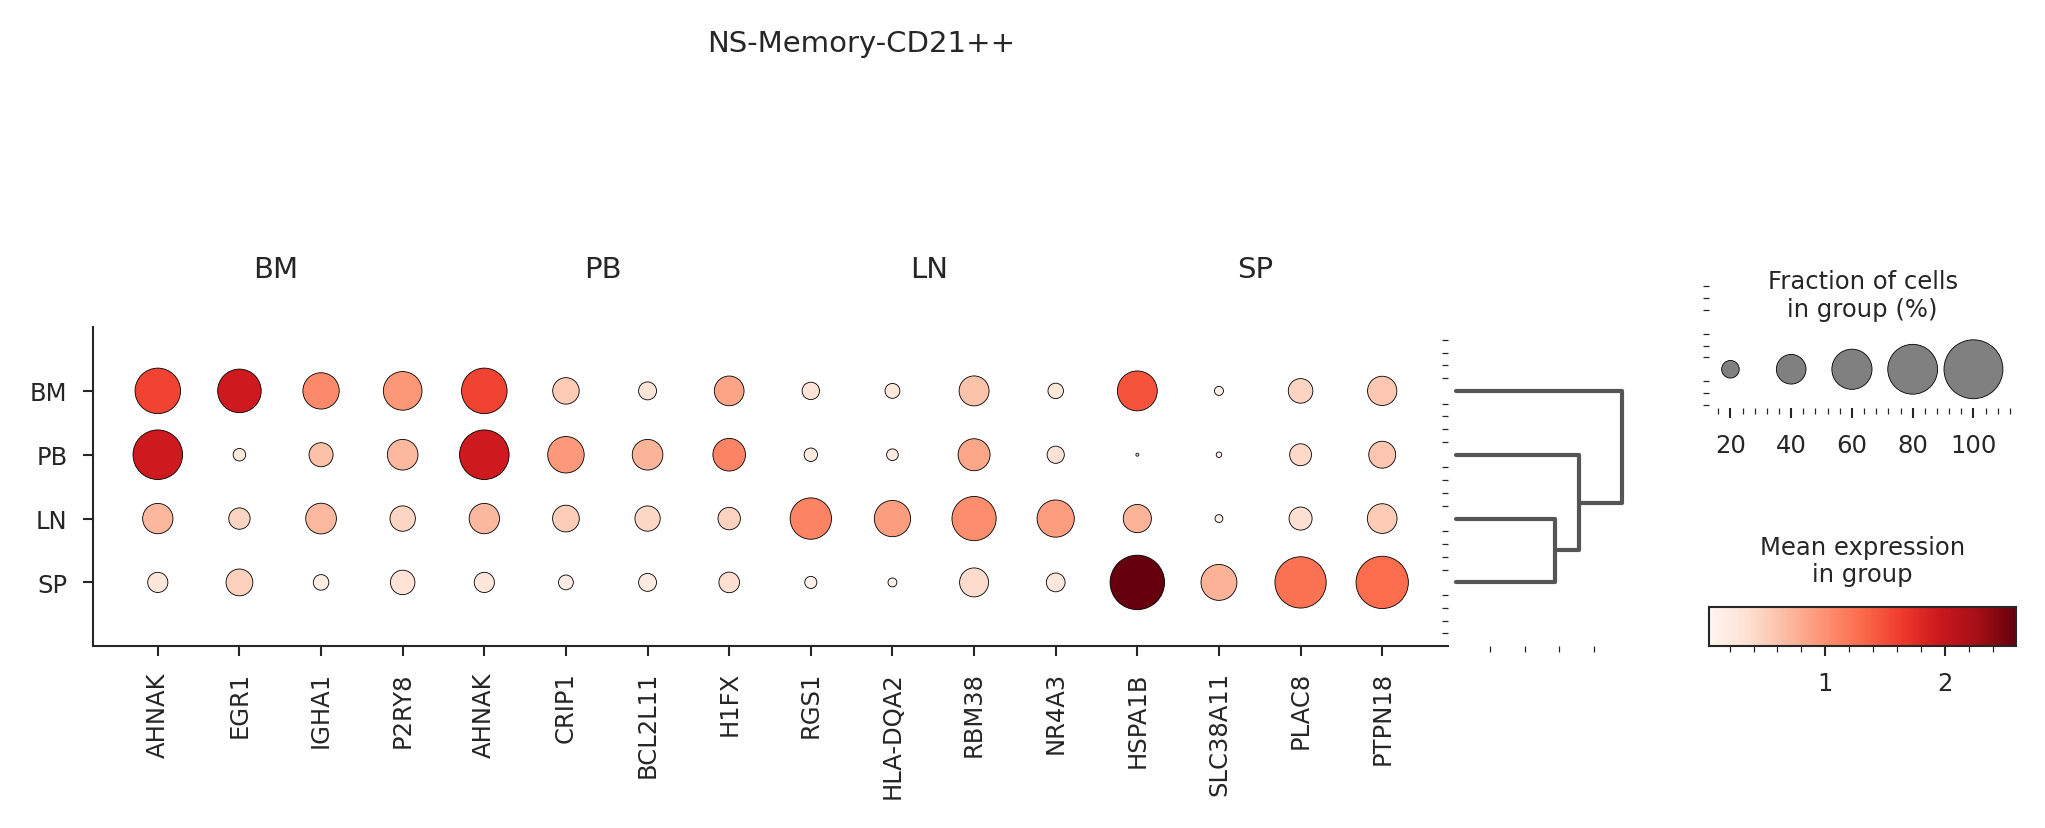

/home/michaelswift/miniconda3/envs/muon3/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


/home/michaelswift/miniconda3/envs/muon3/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


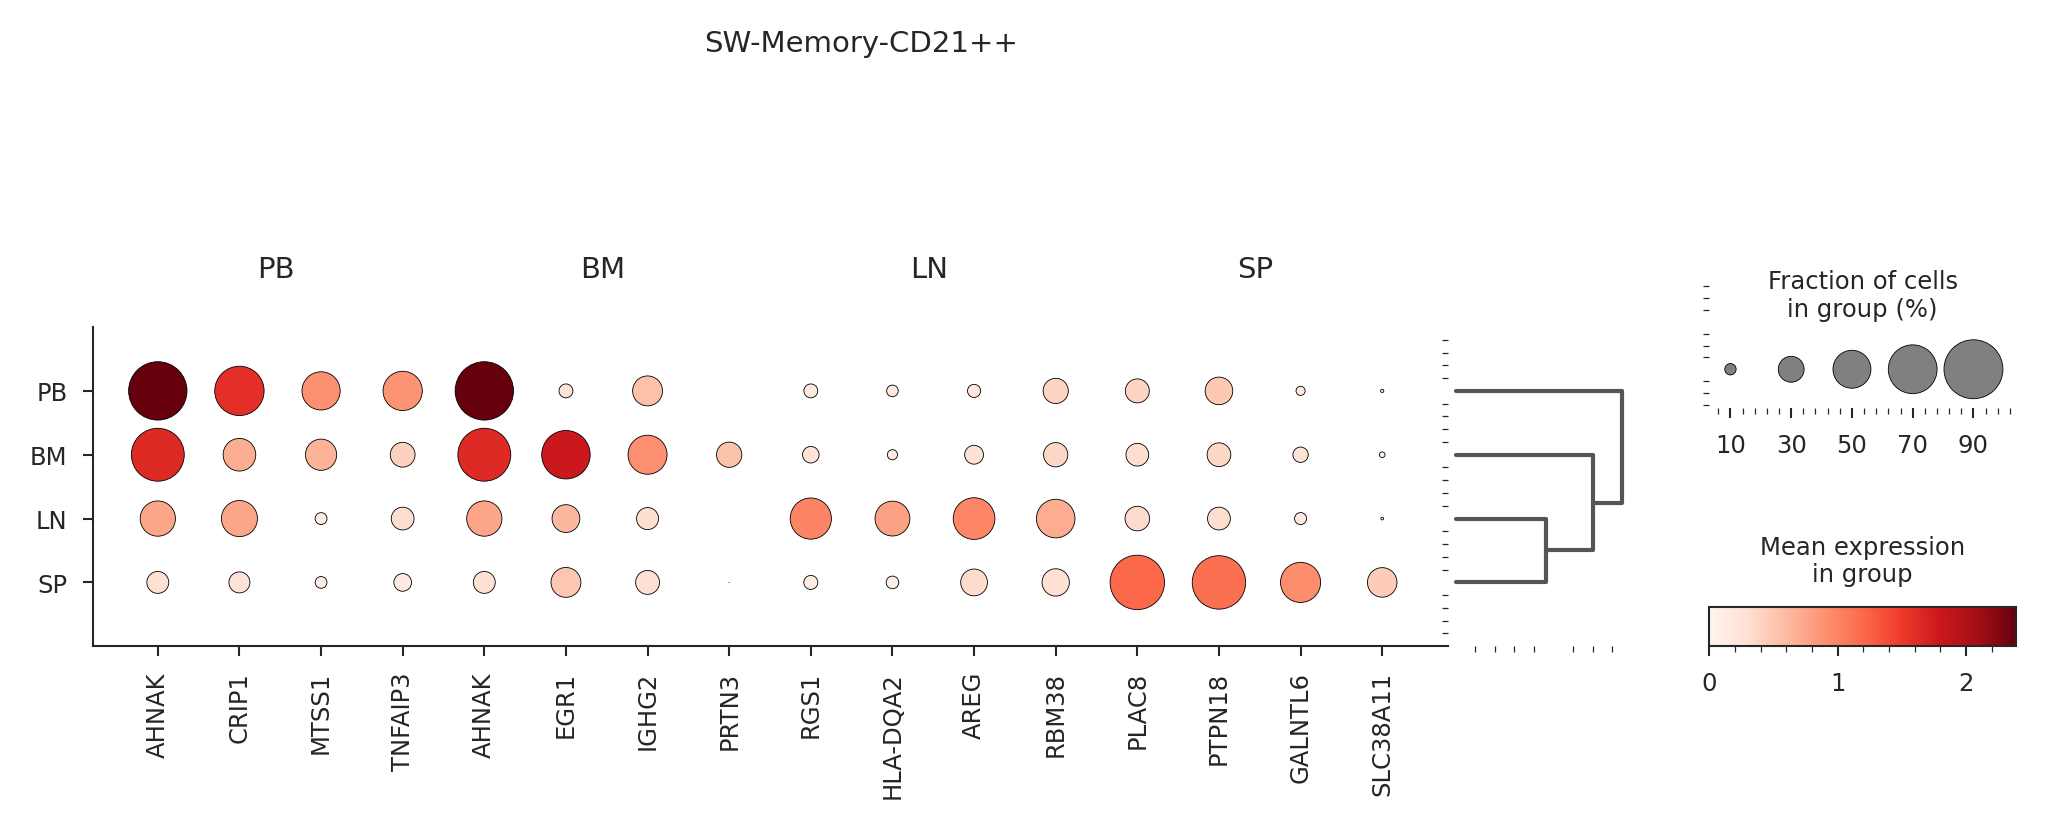

/home/michaelswift/miniconda3/envs/muon3/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


/home/michaelswift/miniconda3/envs/muon3/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


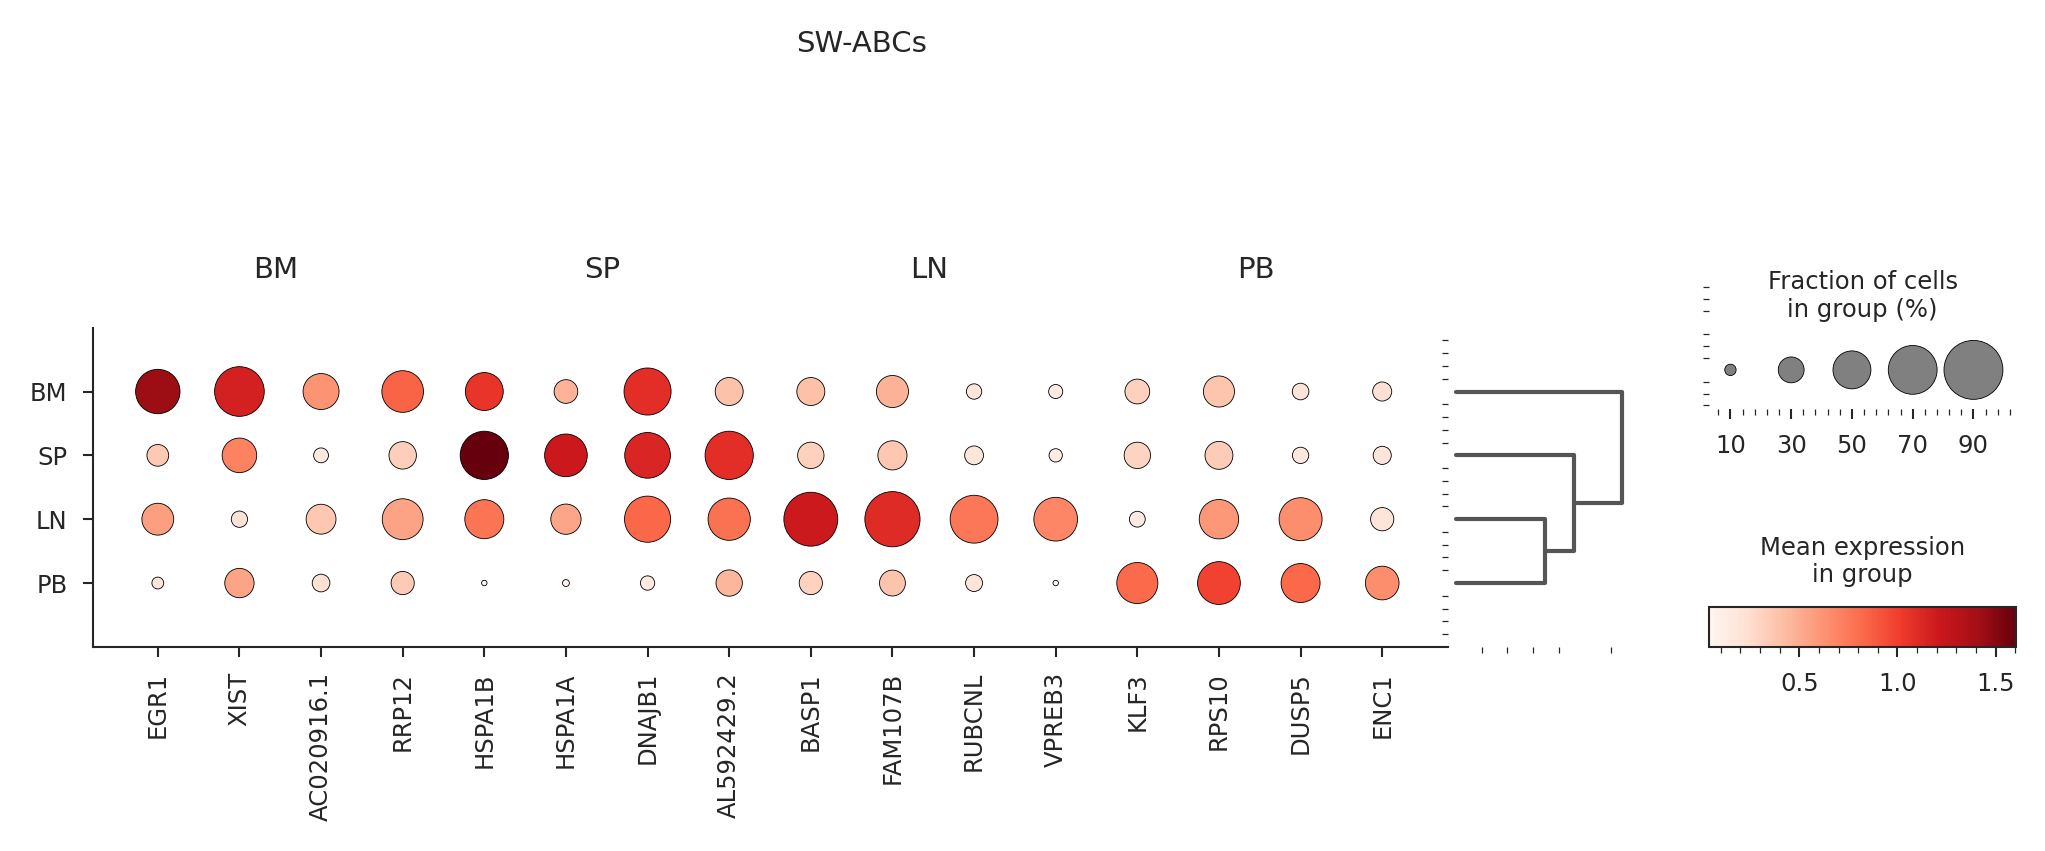

/home/michaelswift/miniconda3/envs/muon3/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


/home/michaelswift/miniconda3/envs/muon3/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


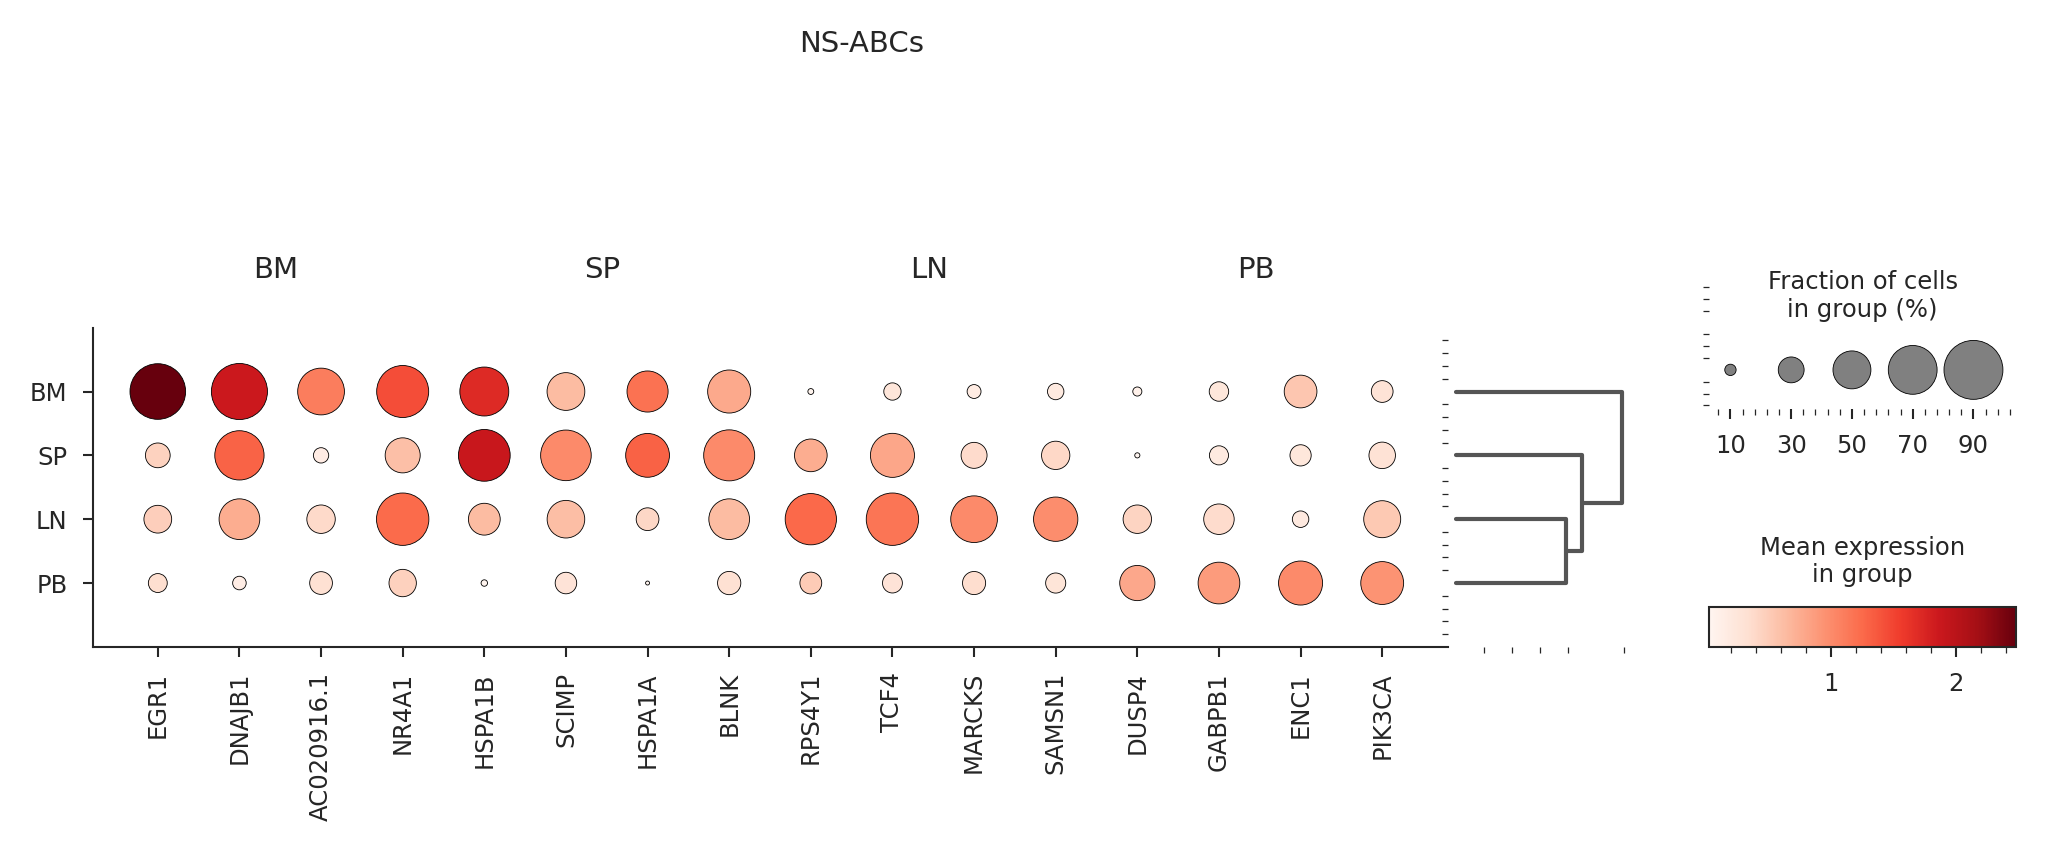

In [23]:
subtypes = adata.obs.subtype.unique()
for subtype in subtypes:
    sub_adata = adata[adata.obs.subtype == subtype]
    sc.tl.rank_genes_groups(sub_adata, groupby = 'tissue')
    sc.tl.filter_rank_genes_groups(
    sub_adata, min_fold_change=1, min_in_group_fraction=0.2, max_out_group_fraction=0.4
)
    sc.pl.rank_genes_groups_dotplot(
    sub_adata, key="rank_genes_groups_filtered", title = subtype, n_genes=4, save=f"{label}", 
)
    #dp = sc.pl.dotplot(adata[adata.obs.subtype == subtype], title = subtype, var_names = markers, groupby= 'tissue', dendrogram=False, figsize = (5,5), swap_axes = True, return_fig=True)
    #dp.add_totals().style(cmap = 'viridis', dot_edge_color='black', largest_dot = 60 , dot_edge_lw=0.7)
    #dp.add_dendrogram().show()
    #save_figure(dp.fig, f"dotplot_{tissue}")

## Relative Abundances of subtypes in Tissues


In [24]:
def range_ci(x):
    return np.min(x), np.max(x)
df = adata.obs
data = selection_helper(df, "subtype", 20)
data = (
    data.groupby(["donor", "tissue"])
    .subtype.value_counts(normalize=True, )
    .rename("fraction")
    .reset_index()
)
# drop zeroes
data=data[data.fraction > 0]

/home/michaelswift/miniconda3/envs/muon3/lib/python3.11/site-packages/seaborn/categorical.py:3025: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try pointplot
  warnings.warn(msg, UserWarning)


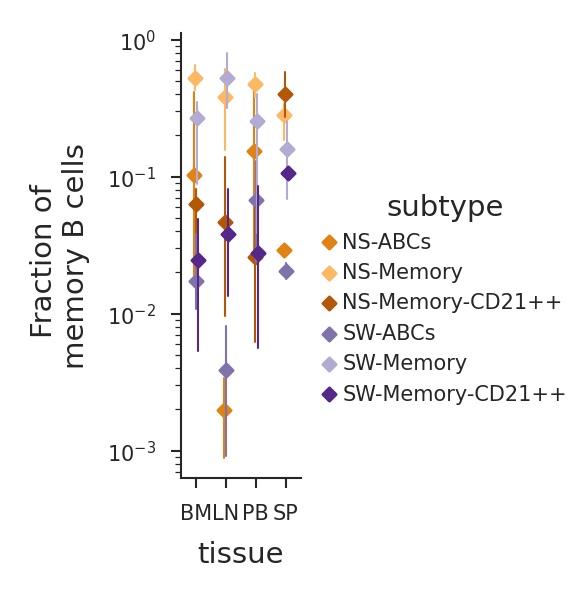

In [25]:
sns.set_style("ticks")
plt.style.use('../bursa.mplstyle')
g = sns.catplot(
    data=data,
    x="tissue",
    y="fraction",
    hue="subtype",
    kind = 'point',
    join = False,
    errorbar = range_ci,
    dodge= 0.14,
    ax = ax,
    palette = get_mb_colors(),
    scale = 0.5, errwidth = 0.5, markers = 'D', height = 2, aspect = 0.6
)

g.set(yscale = 'log', ylabel = "Fraction of \nmemory B cells")
g.ax.tick_params(axis='x', which = 'minor', length=0)
sns.despine()

In [26]:
save_figure(g.figure, f"{celltype}_subtype_abundances_tissue")

## Stacked Bar of isotype fractions by celltype and tissue

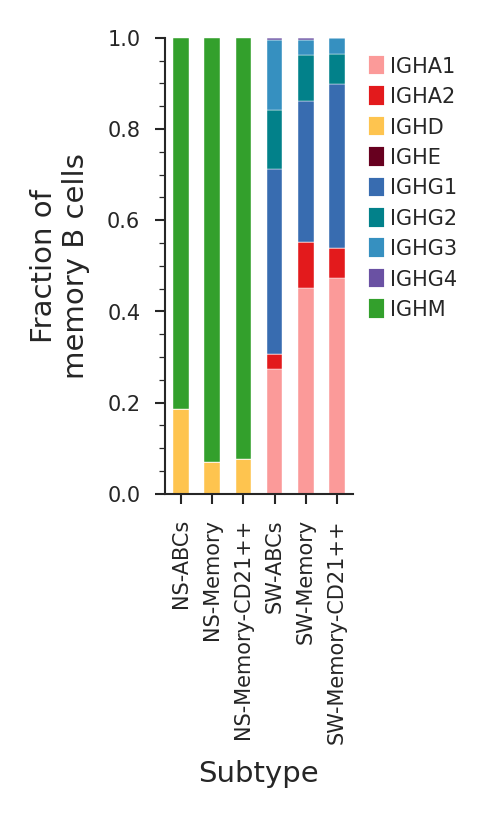

In [27]:
import matplotlib.patches as mpatches
cross_tab = pd.crosstab(df['subtype'], df['c_call'], normalize='index')
fig, ax = plt.subplots(1,1, figsize = (0.8,2))

# Loop over each column (i.e., each stack in the bar)
for i, col in enumerate(cross_tab.columns):
    # Plot this column's data, specify color, add to existing plot (`bottom` parameter)
    cross_tab[col].plot(kind='bar', ax=ax, stacked=True, 
                        color=get_IGH_colors()[col], 
                        bottom = cross_tab.iloc[:, :i].sum(axis=1), linewidth = 0.1)


ax.tick_params(axis='x', which = 'minor', length=0)

# Create a list to store the patches for the legend
patches = []

# Loop over the colors used and create a patch for each
for col in cross_tab.columns:
    patches.append(mpatches.Patch(color=get_IGH_colors()[col], label=col))

# Create the legend

plt.legend(handles=patches, bbox_to_anchor=(1,1))

plt.xlabel('Subtype')
plt.ylabel('Fraction of\nmemory B cells')
plt.show()
save_figure(fig, f"stackedbar_{celltype}_c_call")


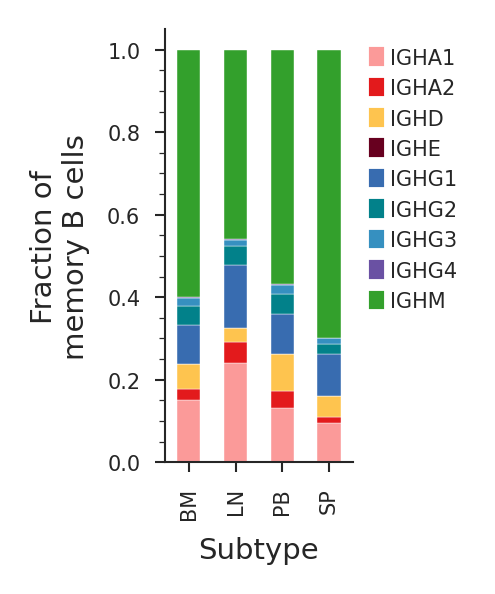

In [28]:
import matplotlib.patches as mpatches
cross_tab = pd.crosstab(df['tissue'], df['c_call'], normalize='index')
fig, ax = plt.subplots(1,1, figsize = (0.8,1.9))

# Loop over each column (i.e., each stack in the bar)
for i, col in enumerate(cross_tab.columns):
    # Plot this column's data, specify color, add to existing plot (`bottom` parameter)
    cross_tab[col].plot(kind='bar', ax=ax, stacked=True, 
                        color=get_IGH_colors()[col], 
                        bottom = cross_tab.iloc[:, :i].sum(axis=1), linewidth = 0.1)


ax.tick_params(axis='x', which = 'minor', length=0)

# Create a list to store the patches for the legend
patches = []

# Loop over the colors used and create a patch for each
for col in cross_tab.columns:
    patches.append(mpatches.Patch(color=get_IGH_colors()[col], label=col))

# Create the legend

plt.legend(handles=patches, bbox_to_anchor=(1,1))
plt.xlabel('Subtype')
plt.ylabel('Fraction of\nmemory B cells')
plt.show()
save_figure(fig, f"stackedbar_{celltype}_c_call")

## Hypermutation by subtype

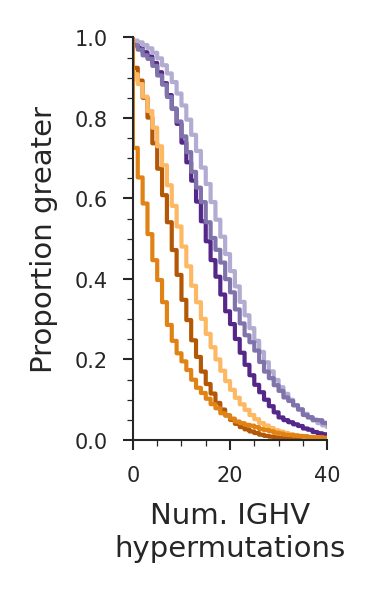

In [29]:
import matplotlib.colors as mcolors
df = adata.obs
g = sns.displot(data = df, x="v_mismatch", hue="subtype", kind = 'ecdf', complementary = True, legend = False, height = 2, aspect = 0.7, palette = get_mb_colors())
g.set(xlim=(0,40), xlabel = "Num. IGHV\nhypermutations", ylabel = "Proportion greater")

g.figure.set_figheight(2)
g.figure.set_figwidth(1.25)
#sns.move_legend(g, "upper right") 
plt.tight_layout()

In [30]:
save_figure(g.figure, f"ecdf_{celltype}")